<center><h1>Visualizing Communities in Movie Viewership</h1></center>
<center><small> Charlie Lu </small><center>

What you watch can tell a lot about what you will watch in the future. Knowing what someone watched and what they like is extremely valuable for companies to retain attention. For viewers, having an idea of what we like could also benefit us in finding content we would enjoy seeing when we want to see it.

Movies are a classic form of entertainment and fortunately for us; user data is widely available in movie review aggregation sites, like [IMDB](https://www.imdb.com/). In this tutorial, I want to explore viewing habits across many movies through the lens of communities that arise from common viewing patterns. 

Communities are collections of items that share something in commonality. In the case of this tutorial, I will be trying to explore communities in movies with the commonality between them being, common viewers.

The inspiration for this idea comes from [this paper on visualizing public data on twitch.](https://towardsdatascience.com/insights-from-visualizing-public-data-on-twitch-a73304a1b3eb) In it, Kiran Gershenfeld uses data from users on the popular live-streaming site [Twitch](twitch.tv) to map streamers on the platform into communities. 

---

## Data Collection

I use Python3 with initially the following imported libraries: [pandas](https://pandas.pydata.org/), [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/), [networkx](https://networkx.org/), and [pyvis](https://pyvis.readthedocs.io/en/latest/) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network

Fortunately, as I stated before, viewer data on movies is readily available. For this tutorial I used a dataset from GroupLens called [MovieLens](https://grouplens.org/datasets/movielens/) that contains "25 million ratings and one million tag applications applied to 62,000 movies by 162,000 users".

The two tables that we will read will be movies.csv and ratings.csv. We read these tables using Pandas.

In [2]:
movies = pd.read_csv("ml-25m/movies.csv")
ratings = pd.read_csv("ml-25m/ratings.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The movies table has 3 columns: 
* movieId
* title
* genres (genres are listed out and delimited by "|")

Every unique movie is given a unique id and a title. These column titles should be fairly self-explanatory.

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


The ratings table has 4 columns:
* userId - Each user has a unique userId that represents reviews given by that user
* movieId - The ID of the movie being reviewed
* rating - A numerical rating 0.5-5 in steps of 0.5 expressing how good a user believes the movie is
* timestamp - A timestamp representing when the review was given

---
## Tidying the Data

25 million ratings from 62,000 movies will take a *long* time so to have a more manageable dataframe we will randomly sample 100000 users. Also we will be dropping the "timestamp" column as we not be using it and thus make the dataframe more manageable.

In [4]:
sample_ratings = ratings[ratings.userId.isin(np.random.choice(ratings.userId.unique(),50000, replace=False))]
sample_ratings = sample_ratings.drop(columns = ['timestamp'])
sample_ratings.groupby('userId') \
              .count() \
              .sort_values(['movieId'], ascending=False)

,movieId,rating
userId,,
137293,8913,8913
109731,6647,6647
110971,5633,5633
78849,5276,5276
29803,5219,5219
...,...,...
60610,20,20
11404,20,20
40643,20,20


Here we see that there are 1000 rows representing the users that were sampled.

In [5]:
sample_ratings.groupby('movieId') \
              .count() \
              .sort_values(['userId'], ascending=False)

,userId,rating
movieId,,
318,25189,25189
356,25137,25137
296,24591,24591
593,22791,22791
2571,22361,22361
...,...,...
150558,1,1
150562,1,1
150564,1,1


The number of movies that were sampled then were also reduced.

### Merging the Data

I then join the two tables on 'movieId'. This way we have all the data on one table that we can manipulate. We will also drop any rows with N/A values indicating no reviews were made on it.

In [6]:
rm = sample_ratings.merge(movies, on='movieId').dropna()
rm.head()

,userId,movieId,rating,title,genres
0,1,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,3,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,5,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,10,296,4.5,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,26,296,3.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


Now if we want to easily be able to use the genres listed for each title, we will manipulate the table to include a column for each genre.

In [7]:
rmx = rm['genres'].str.get_dummies(sep='|')
rm = pd.concat([rm, rmx], axis=1).drop(columns=['genres'])
rm.head()

,userId,movieId,rating,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,296,5.0,Pulp Fiction (1994),0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,3,296,5.0,Pulp Fiction (1994),0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,5,296,4.0,Pulp Fiction (1994),0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,10,296,4.5,Pulp Fiction (1994),0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,26,296,3.0,Pulp Fiction (1994),0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In order to get the correct year the movie was released in as a column I used a regex on the title column as they contain the year in parentheses. I did this to make it easier to sort by year later in data exploration.

In [79]:
# regex for extracting the year
regex_year = "\((\d{4})\)$"

# extracting year from the title using str.extract
rm['year'] = rm['title'].str.extract(r'\((\d{4})\)$')

# I chose to drop any columns where a year was not found.
rm = rm.dropna()

# Casting year as in integer
rm.astype({'year': 'int32'})
rm.head()

,userId,movieId,rating,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,296,5.0,Pulp Fiction (1994),0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1994
1,3,296,5.0,Pulp Fiction (1994),0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1994
2,5,296,4.0,Pulp Fiction (1994),0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1994
3,10,296,4.5,Pulp Fiction (1994),0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1994
4,26,296,3.0,Pulp Fiction (1994),0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1994


---
## Data Exploration

In this section, we'll explore the data that we tidied in the previous section. Data exploration is done in order to understand characteristics of the data. We'll attempt various approaches to see whether there are relationships within the data.

### Distribution of Average Ratings Over all Movies

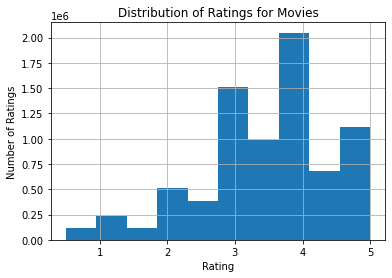

In [80]:
ax = rm.hist(column = 'rating')

plt.title('Distribution of Ratings for Movies')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

This histogram shows that the distribution for ratings for this sample is left skewed. Another point of interest that can be seen are the smaller peaks that occur at the whole number intervals. This shows a tendency for reviewers to be more likely to give whole number ratings over decimal.

### What is the highest rated movie, according to our sample?

In [81]:
# Group by titles and get the mean 
means=rm[['title','rating']].groupby('title').mean()
# Display the 10 greatest ratings
means.nlargest(10, columns=['rating'])

,rating
title,
'49-'17 (1917),5.0
(Girl)Friend (2018),5.0
...E fuori nevica! (2014),5.0
15 Février 1839 (2001),5.0
26 Years (2012),5.0
3 Idiotas (2017),5.0
50 Children: The Rescue Mission of Mr. And Mrs. Kraus (2013),5.0
A Borrowed Life (1994),5.0
A Daughter's Nightmare (2014),5.0


Our finding above seems to suggest that there is a large tie for the highest rated movie. This however is misleading as the cause for all these high rated movies is a small sample size of reviewers rating the movie. To fix this, we need to filter out all the movies that have a sample size that is too low.

In [82]:
# Group by titles
result = rm[['title','rating']].groupby('title')
#Filter out results with low sample sizes
result = result.filter(lambda x : len(x)>100) # We choose samples with greater than 100 reviews.

# Group by titles once again and get the mean
mean_sample = result.groupby('title').mean()

# Display the 10 greatest ratings
mean_sample.nlargest(10, ['rating'])

,rating
title,
Planet Earth II (2016),4.487968
Planet Earth (2006),4.435201
"Shawshank Redemption, The (1994)",4.414764
Blue Planet II (2017),4.385650
Band of Brothers (2001),4.374710
"Godfather, The (1972)",4.326890
There Once Was a Dog (1982),4.294118
Parasite (2019),4.283537
"Usual Suspects, The (1995)",4.281461


These 10 highest ratings are a much better representation of what movies can be considered the top. Once we remove all the items with low sample sizes, we can have a much better idea of what the true population rates movies. As it stands, a larger set of data will give more results with better confidence. For our sample, we see that Planet Earth II (2016) is the highest rated movie.

---
## Community Visualization

For this section, we will attempt to visualize the communities that may arise in movie watchers. For this section, I chose to further decrease the number of movies that we are mapping so that the visualization is less cluttered. I chose to do this by only including the movies that had more than a certain number of reviews on it. By limiting the number of views, we reduce the number of movies that appear in the final mapping. This makes for a much more understandable map.

In [104]:
r = rm[['title','userId']].groupby('title').filter(lambda x : len(x)>10000)
r.groupby('title').count().nlargest(10, ['userId'])

,userId
title,
"Shawshank Redemption, The (1994)",25189
Forrest Gump (1994),25137
Pulp Fiction (1994),24591
"Silence of the Lambs, The (1991)",22791
"Matrix, The (1999)",22361
Star Wars: Episode IV - A New Hope (1977),21186
Jurassic Park (1993),19741
Schindler's List (1993),18660
Fight Club (1999),18246


Now the way in which we are mapping movies is to map the viewer overlap between movies. To do this, we must create an [adjacency matrix](https://mathworld.wolfram.com/AdjacencyMatrix.html) representing the network of movies. To do this we make use of the Pandas [crosstab](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html) function.

In [105]:
# Merge the dataframe with itself on userId in order to create a 
# dataframe in which each row represents a pair of movies.
ratings_merge = r.merge(r, on='userId')

# Cross tab on the titles to create pandas table representing the network
results = pd.crosstab(ratings_merge.title_x, ratings_merge.title_y)

# Reindex
idx = results.columns.union(results.index)
results = results.reindex(index = idx, columns=idx, fill_value=0)

results

,Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),Apollo 13 (1995),Back to the Future (1985),Batman (1989),Beauty and the Beast (1991),Blade Runner (1982),...,Star Wars: Episode VI - Return of the Jedi (1983),Terminator 2: Judgment Day (1991),"Terminator, The (1984)",Titanic (1997),Toy Story (1995),True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Usual Suspects, The (1995)",X-Men (2000)
Ace Ventura: Pet Detective (1994),11499,7389,3806,2930,4729,7803,5354,8000,6175,3653,...,5099,7525,4454,4531,6248,7643,4010,5851,5933,3823
Aladdin (1992),7389,13356,4224,3143,5015,8300,6161,8293,8842,4110,...,6285,7912,4802,5135,8099,7522,4385,5935,6202,4185
Alien (1979),3806,4224,11164,4003,6492,4879,7623,4978,3361,7037,...,7894,7849,7670,4954,6227,4593,4809,6284,6418,4880
"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",2930,3143,4003,10606,6799,3381,5169,2930,2614,4345,...,4777,4457,4000,4366,4939,2739,4708,4337,5669,4010
American Beauty (1999),4729,5015,6492,6799,16504,5848,8558,5136,3994,6627,...,8084,7849,6876,7163,7884,4974,6872,6968,9129,6012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
True Lies (1994),7643,7522,4593,2739,4974,8868,5835,9159,6251,4380,...,6068,9198,5356,4585,6682,12858,3899,6675,6971,3946
"Truman Show, The (1998)",4010,4385,4809,4708,6872,4917,6659,3990,3537,4841,...,6201,5951,5421,5994,6322,3899,10474,5264,5944,4836
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),5851,5935,6284,4337,6968,7080,7274,6877,4689,6596,...,7962,9041,6628,5242,8186,6675,5264,14511,8501,4910
"Usual Suspects, The (1995)",5933,6202,6418,5669,9129,7783,7840,7145,5027,6922,...,7946,9299,6772,5790,8018,6971,5944,8501,17196,5231


Each row, column pair represents the number of review overlap between the two movies. 

We will use the adjacency matrix we created for the edge weights of the graph. In order to weight the diagram appropriately, I chose to use min-max normalization so that the weights range from 0-1. More about min-max normalization can be learned [here](https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79) or [here](https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0)

In [91]:
rmin = results.min().min() # absolute minimum value in the dataframe
np.fill_diagonal(results.values, 0)

rmax = results.max().max()# absolute maximum value in the dataframe

r_std = results.transform(lambda y: (y - rmin) / (rmax-rmin))# Apply min-max normalization

np.fill_diagonal(r_std.values, 0)
r_std

,Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),Apollo 13 (1995),Back to the Future (1985),Batman (1989),Beauty and the Beast (1991),Blade Runner (1982),...,Star Wars: Episode VI - Return of the Jedi (1983),Terminator 2: Judgment Day (1991),"Terminator, The (1984)",Titanic (1997),Toy Story (1995),True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Usual Suspects, The (1995)",X-Men (2000)
Ace Ventura: Pet Detective (1994),0.000000,0.369535,0.141840,0.086172,0.200496,0.395844,0.240214,0.408363,0.292387,0.132117,...,0.224009,0.378177,0.183020,0.187913,0.297026,0.385676,0.154804,0.271797,0.277008,0.142921
Aladdin (1992),0.369535,0.000000,0.168404,0.099708,0.218671,0.427428,0.291497,0.426983,0.461871,0.161159,...,0.299377,0.402771,0.205135,0.226296,0.414654,0.377987,0.178635,0.277135,0.294103,0.165925
Alien (1979),0.141840,0.168404,0.000000,0.154359,0.312532,0.210028,0.384405,0.216319,0.113561,0.347166,...,0.401627,0.398767,0.387392,0.214794,0.295691,0.191853,0.205580,0.299314,0.307829,0.210092
"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",0.086172,0.099708,0.154359,0.000000,0.332041,0.114832,0.228457,0.086172,0.066090,0.176093,...,0.203546,0.183210,0.154169,0.177428,0.213841,0.074034,0.199161,0.175585,0.260231,0.154804
American Beauty (1999),0.200496,0.218671,0.312532,0.332041,0.000000,0.271607,0.443823,0.226360,0.153787,0.321111,...,0.413701,0.398767,0.336934,0.355173,0.400991,0.216065,0.336680,0.342781,0.480109,0.282028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
True Lies (1994),0.385676,0.377987,0.191853,0.074034,0.216065,0.463523,0.270780,0.482016,0.297217,0.178317,...,0.285587,0.484494,0.240341,0.191345,0.324606,0.000000,0.147750,0.324161,0.342972,0.150737
"Truman Show, The (1998)",0.154804,0.178635,0.205580,0.199161,0.336680,0.212443,0.323144,0.153533,0.124746,0.207613,...,0.294039,0.278152,0.244471,0.280885,0.301729,0.147750,0.000000,0.234494,0.277707,0.207295
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),0.271797,0.277135,0.299314,0.175585,0.342781,0.349898,0.362227,0.336998,0.197954,0.319141,...,0.405948,0.474517,0.321174,0.233096,0.420183,0.324161,0.234494,0.000000,0.440201,0.211998
"Usual Suspects, The (1995)",0.277008,0.294103,0.307829,0.260231,0.480109,0.394573,0.398195,0.354029,0.219433,0.339858,...,0.404931,0.490913,0.330325,0.267921,0.409507,0.342972,0.277707,0.440201,0.000000,0.232397


## Viewing the Mapping

First we will attempt to map the movies without communities using [networkx](https://networkx.org/). Networkx is useful because it has built in functions to convert a pandas adjacency matrix into a network graph using [from_pandas_adjacency](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_adjacency.html). 

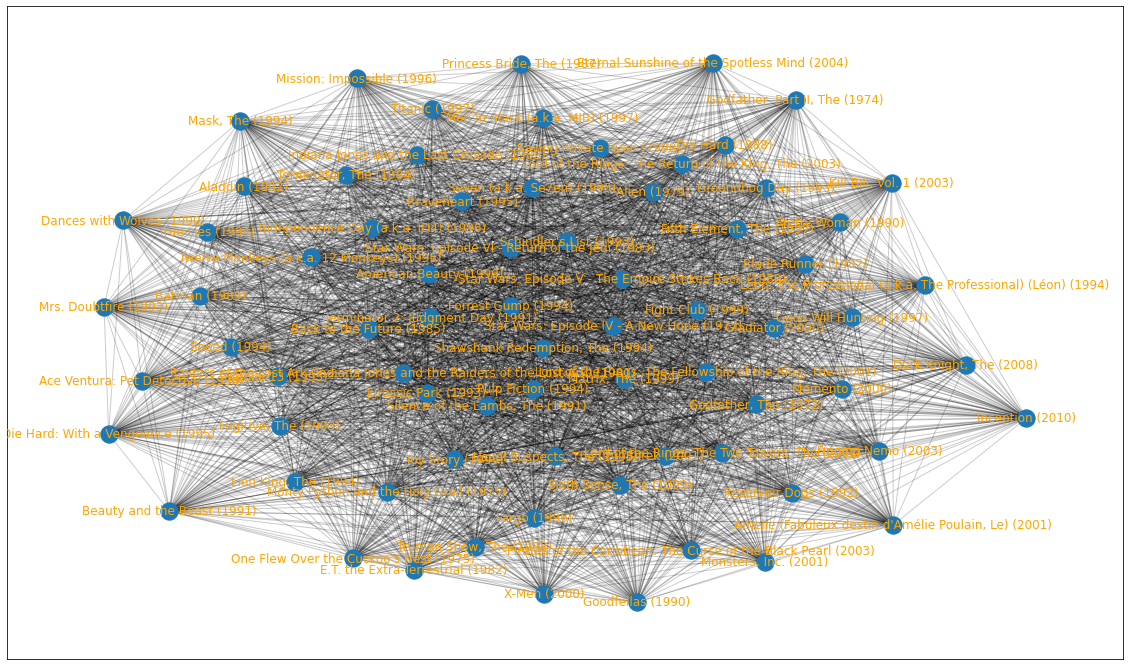

In [124]:
G = nx.from_pandas_adjacency(r_std)

# Set figure size to be larger
plt.figure(3,figsize=(20,12)) 

# Use spring physics for layout
pos = nx.spring_layout(G)

# Draw network
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G,pos,font_size=12, font_color = 'orange')

plt.show()

With such a dense matrix, keep in mind that we are greatly reducing the amount of dimensions to just 2 so that we could view it. There could be some quirks that arise in movies that may not be close matches with each other but were pulled into place in the 2d field by the myriad of other movies. It nevertheless is interesting to see which movies are close to each other. 

From this distribution we can see certain nodes are slightly closer to each other than others. However, there does not seem to be obvious communities within these movies and overall the spread seems to be homogeneous.

## Community Detection

For community detection, I decided to go with an algorithm from a package called [community](https://python-louvain.readthedocs.io/en/latest/api.html). The algorithm that is used is from the Louvain method for community detection which optimizes by greedily grouping small communities into nodes. I set the resolution for the algorithm, which defines the size of communities as described [here](https://arxiv.org/abs/0812.1770), to be 0.85. More on the louvain method can be learned from [here](https://towardsdatascience.com/louvain-algorithm-93fde589f58c) or from the package linked.

[matplolib.cm](https://matplotlib.org/stable/api/cm_api.html) was also imported. This package lets us easily color our nodes so we can keep track of the communities in our visualization.

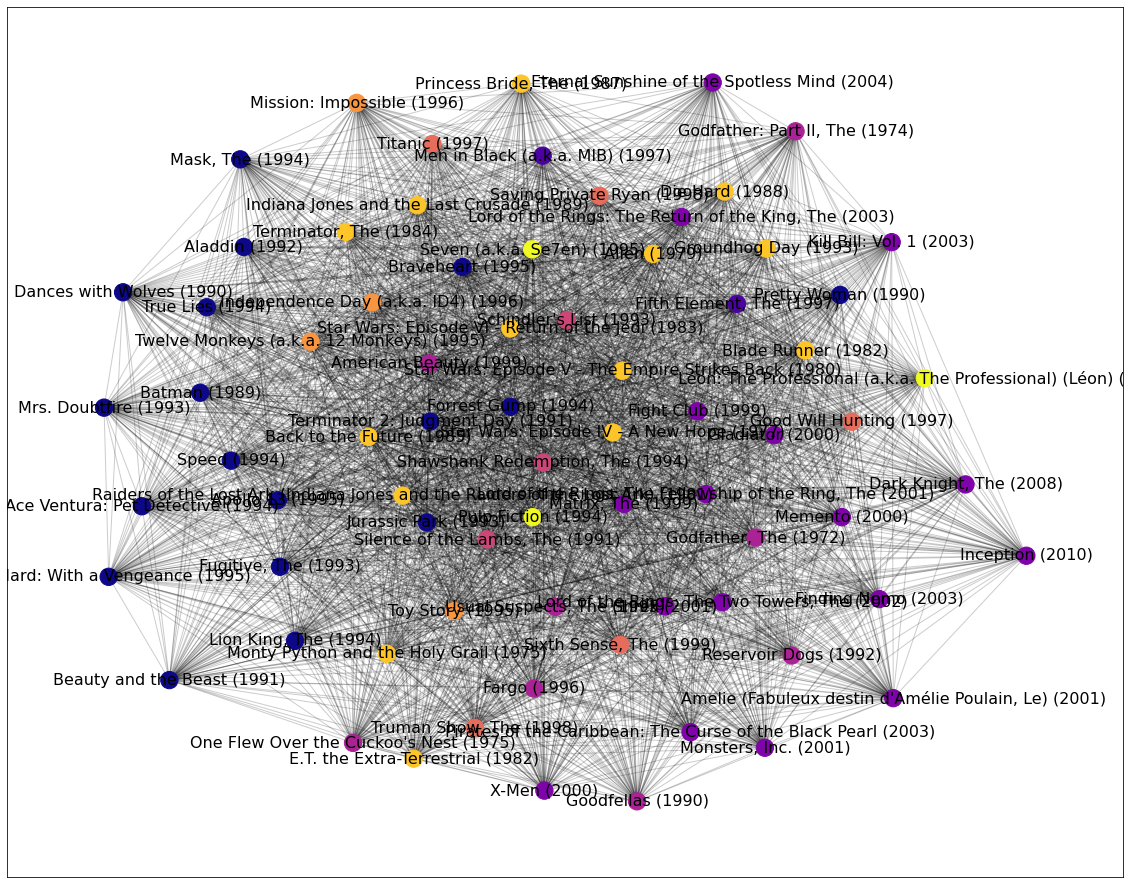

In [126]:
from community import community_louvain
import matplotlib.cm as cm

plt.figure(3,figsize=(20,16)) 

# Partition using the louvain method
partition = community_louvain.best_partition(G, weight = 'weight', resolution=0.85)
cmap = cm.get_cmap('plasma', max(partition.values()) + 1) #colormap of nodes

# draw nodes
nx.draw_networkx_nodes(G, pos, partition.keys(), 
                        cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G,pos,font_size=16, font_color = 'black')
plt.show()

The louvain-method seems to have been somewhat succesful in visualizing communities in conjunction with the networkx draw function. We can see certain areas of the graph are more dense in certain amounts. Some communities, though, are not physically  near each other in the visualization. For instance, the three yellow nodes representing a community are very far apart. 

Next, we'll attempt to graph using a more dynamic graphing tool [pyvis](https://pyvis.readthedocs.io/en/latest/). Pyvis has many tools for forming a dynamic graph. The settings I chose in the "physics" section uses what's known as a [Barnes–Hut simulation](http://arborjs.org/docs/barnes-hut) to group the nodes. Gravitation constant is a number representing how much force the nodes repel each other, spring length represents the minimum edge length, and spring constant represents how force at which the nodes attract each other. A tutorial of a pyvis network visualization can be found [here](https://pyvis.readthedocs.io/en/latest/tutorial.html). 

In [131]:
nodes = G.nodes.data()
edges = G.edges.data()
g = Network(notebook=True)
cmap = ['darkred','red','orange','yellow','green','blue','darkblue','purple','violet']
{g.add_node(node[0], color = cmap[partition[node[0]]]) for node in nodes}
{g.add_edge(edge[0], edge[1], value = edge[2]['weight']) for edge in edges}
g.set_options('''var options = {
                "nodes": {"color": { "hover": { "border": "rgba(231,44,233,1)"}},"shape": "dot" },
                "edges": {"arrowStrikethrough": false, 
                "color": {"opacity": 0.25, "highlight": "rgba(132,48,51,1)", "hover": "rgba(128,25,132,1)", "inherit": false },
                "smooth": { "type": "vertical", "forceDirection": "none" }},  
                "physics": {"barnesHut": { "gravitationalConstant": -8000, "springLength": 250,"springConstant": 0.001},
                "minVelocity": 0.75  }}''')
g.show("ex.html")

This method seems less successful in keeping the communities closer together; however, it is manually readjustable. In addition the benefit to this method is that the width of the edges correlate to the amount of viewership overlap two movies have. Two movies with a large overlap of viewership will have a thicker line connecting the two than movies with little viewership. This way, how related two specific movies are can be seen a little more clearly using this method of visualization. 

## Analysis
### Understanding the communities
Now let's view the communities that the Louvain-method has generated and see if we can find any commonalities within them.

In [157]:
partdf = pd.DataFrame.from_dict(partition,orient='index',columns=['community'])
partdf.loc[partdf['community'] == 0]

,community
Ace Ventura: Pet Detective (1994),0
Aladdin (1992),0
Apollo 13 (1995),0
Batman (1989),0
Beauty and the Beast (1991),0
Braveheart (1995),0
Dances with Wolves (1990),0
Die Hard: With a Vengeance (1995),0
Forrest Gump (1994),0
"Fugitive, The (1993)",0


From first glance, we can see all the movies in this section came around the early 90s. This makes sense as we can guess that people who watched movies in the 90s will be more likely to have seen other movies in the 90s. I would cautiously call this section family movies from around the early 90s. Although Terminator 2 is in this community, this community does contain all of the Disney princess movies and other classic family movies such as "Jurassic Park" and "Forrest Gump" among others.

In [158]:
partdf.loc[partdf['community'] == 1]

,community
"Fifth Element, The (1997)",1
Men in Black (a.k.a. MIB) (1997),1


This community only contains two movies both from 1997. The most likely had significant overlap due to the fact they are both science fiction. As such, I'll call this 90's science-fiction.

In [159]:
partdf.loc[partdf['community'] == 2]

,community
"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",2
"Dark Knight, The (2008)",2
Eternal Sunshine of the Spotless Mind (2004),2
Fight Club (1999),2
Finding Nemo (2003),2
Gladiator (2000),2
Inception (2010),2
Kill Bill: Vol. 1 (2003),2
"Lord of the Rings: The Fellowship of the Ring, The (2001)",2
"Lord of the Rings: The Return of the King, The (2003)",2


This community contains all the movies that are from around the 2000s. A reason for this could be that movie reviewing became more prevalent as personal devices did therefore making the viewership overlap between all movies from 2000 greater. It is interesting to see though

In [160]:
partdf.loc[partdf['community'] == 3]

,community
American Beauty (1999),3
Fargo (1996),3
"Godfather, The (1972)",3
"Godfather: Part II, The (1974)",3
Goodfellas (1990),3
One Flew Over the Cuckoo's Nest (1975),3
Reservoir Dogs (1992),3
"Usual Suspects, The (1995)",3


This community is the first thus far to not contain only movies within around a 10-year time period. I would call this community the "crime drama" community as they feature movies containing elements like the mafia and gun violence.

In [161]:
partdf.loc[partdf['community'] == 4]

,community
Schindler's List (1993),4
"Shawshank Redemption, The (1994)",4
"Silence of the Lambs, The (1991)",4


This community is interesting to me because they are all from different genres. Schindler's List is a historical drama, The Shawshank Redemption is a crime drama, and The Silence of the Lambs is a psychological horror film. Yet these three films do share a commonality of a character struggling against oppressive and/or deadly forces. I will cautiously call this section "Early 90s Character Dramas".

In [162]:
partdf.loc[partdf['community'] == 5]

,community
Good Will Hunting (1997),5
Saving Private Ryan (1998),5
"Sixth Sense, The (1999)",5
Titanic (1997),5
"Truman Show, The (1998)",5


These are all movies from the years 1997-1999, yet this section does not contain Men in Black or The Fifth Element. I'll call this section dramas from the late 90s.

In [163]:
partdf.loc[partdf['community'] == 6]

,community
Independence Day (a.k.a. ID4) (1996),6
Mission: Impossible (1996),6
Toy Story (1995),6
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),6


I could probably categorize these movies easily if not for Toy Story being in there. This could be a quirk from the sample or from the community detection algorithm. One would think Toy Story would be grouped with the family films category. For now, I'll cautiously call this section Action films from the mid 90s.|

In [164]:
partdf.loc[partdf['community'] == 7]

,community
Alien (1979),7
Back to the Future (1985),7
Blade Runner (1982),7
Die Hard (1988),7
E.T. the Extra-Terrestrial (1982),7
Groundhog Day (1993),7
Indiana Jones and the Last Crusade (1989),7
Monty Python and the Holy Grail (1975),7
"Princess Bride, The (1987)",7
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),7


This final section I will seems to be mainly family action films. We can see certain community of movies that we would most likely have imagined being together such as the Star Wars series and Indiana Jones. 

### Key Takeaways

In hindsight, it seems pretty obvious that there will be a lot of viewership overlap for movies that release in similar time intervals and the communities that my tutorial detected reflected this. Now this isn't to say the content of the movies has a lesser role. I was quite pleasantly surprised to see what I call the "Crime Drama" community contain movies of similar material yet were very disparate in release date comparatively to the other communities. From this tutorial, I concluded that both year released and contents of movies have a big impact on the overlap of viewership movies have. 

## Conclusion

Movies are a classic form of media that fortunately has widely available user data and this tutorial is my honest shot at mapping a select number of popular ones. 

Through this tutorial I learned a lot that built off of material from my Introduction to Data Science course, CMSC320. In the class, we briefly went over community detection and network visualization, which piqued my interest. I chose to do only a single community detection algorithm only based on viewership because of how much I had to learn outside of the class. I wanted to keep it simple for both myself and for this tutorial. 

The success of this tutorial in finding communities is subjective but the fact people have unique tastes and don't watch every single movie means that these communities *do* exist. This tutorial takes a rather simplistic approach to a definition of a community of movies by only taking into account viewership. Yet, viewing two movies does not necessarily mean they should be weighted closer to each other in a map. If you enjoy one movie but dislike the other, it should mean that they are not good candidates to be put in a community together. 

Basing purely on viewership overlap may not be the best metric for finding communities within movies. I know that there are many improvements that could be done to visualize these communities. With a larger sample size and a higher limit on the number of movies to display perhaps the similarities within communities will become more pronounced over more than just release date. Nevertheless, even if you are not interested in mapping communities in movies, the contents of this tutorial could be used as a reference in your own method in visualizing and defining communities in whatever medium you choose.